In [44]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [61]:
dataset = 'ihart'
deletion_dir = '../deletions_%s' % dataset
ped_file = '../data/v34.vcf.ped'

#deletion_dir = '../deletions_spark_exome'
#ped_file = '../data/spark_jae_adj.ped'

chroms = [str(x) for x in range(1, 23)]

In [62]:
all_deletions = []

for chrom in chroms:
    print(chrom, end=' ')
    
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
    all_deletions.extend(deletions)
                          
                          

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [63]:
# pull cytobands
intervals = []

with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()

# filter deletions that go through the centromere
centromeres = [x for x in intervals if x[-1] == 'acen']
centromere_deletions = set()
for i, d in enumerate(all_deletions):
    for chrom, _, start_pos, end_pos, _ in centromeres:
        if d['chrom'] == chrom:
            if d['start_pos'] >= start_pos and d['start_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['end_pos'] >= start_pos and d['end_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                centromere_deletions.add(i)
print('centromere deletions', len(centromere_deletions)) 

all_deletions = [d for i, d in enumerate(all_deletions) if i not in centromere_deletions]

centromere deletions 4298


In [64]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


# Deletion lengths

2 2699732 4776.0
7 11979734 27664.0


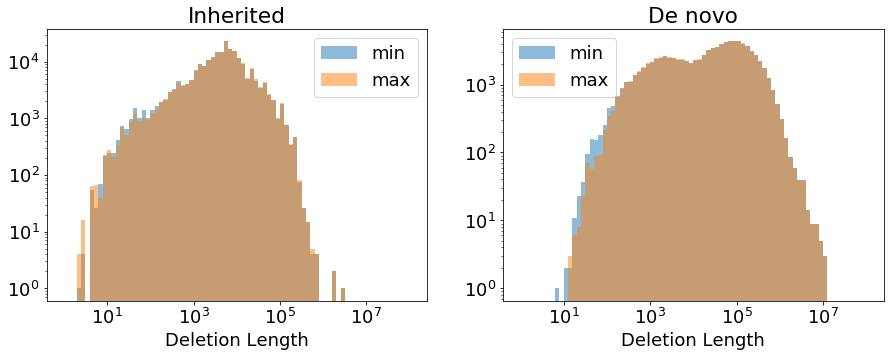

In [65]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
all_lengths = [d['length'] for d in all_deletions if not d['is_denovo']]
print(np.min(all_lengths), np.max(all_lengths), np.median(all_lengths))
plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='min')
all_opt_lengths = [d['opt_end_pos']-d['opt_start_pos'] for d in all_deletions if not d['is_denovo']]
plt.hist(np.clip(all_opt_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='max')
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('Inherited')
plt.legend()

plt.subplot(1, 2, 2)
all_lengths = [d['length'] for d in all_deletions if d['is_denovo']]
print(np.min(all_lengths), np.max(all_lengths), np.median(all_lengths))
plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='min')
all_opt_lengths = [d['opt_end_pos']-d['opt_start_pos'] for d in all_deletions if d['is_denovo']]
plt.hist(np.clip(all_opt_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label='max')
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('De novo')
plt.legend()
plt.show()

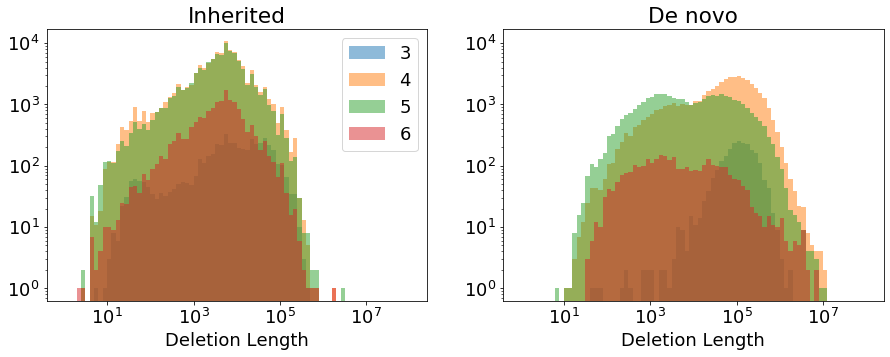

In [66]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
for famsize in [3, 4, 5, 6]:
    all_lengths = [d['length'] for d in all_deletions if not d['is_denovo'] and d['family_size'] == famsize]
    plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label=str(famsize))
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('Inherited')
plt.legend()

plt.subplot(1, 2, 2, sharey=ax)
for famsize in [3, 4, 5, 6]:
    all_lengths = [d['length'] for d in all_deletions if d['is_denovo'] and d['family_size'] == famsize]
    plt.hist(np.clip(all_lengths, None, 10**8), bins=np.power(10.0, np.arange(0, 8.1, 0.1)), log=True, alpha=0.5, label=str(famsize))
plt.xscale('log')
plt.xlabel('Deletion Length')
plt.title('De novo')
plt.show()

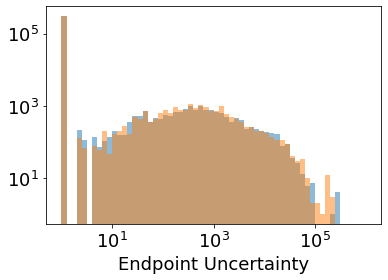

In [67]:
start_uncertainty = [d['start_pos']-d['opt_start_pos'] for d in all_deletions]
plt.hist(np.clip(start_uncertainty, 1, 10**6), bins=np.power(10.0, np.arange(0, 6.1, 0.1)), log=True, alpha=0.5)
end_uncertainty = [d['opt_end_pos']-d['end_pos'] for d in all_deletions]
plt.hist(np.clip(end_uncertainty, 1, 10**6), bins=np.power(10.0, np.arange(0, 6.1, 0.1)), log=True, alpha=0.5)

plt.xscale('log')
plt.xlabel('Endpoint Uncertainty')
plt.show()

# Deletions per individual

In [68]:
child_to_inh_mat_dels = defaultdict(int)
child_to_inh_pat_dels = defaultdict(int)
child_to_denovo_mat_dels = defaultdict(int)
child_to_denovo_pat_dels = defaultdict(int)

mom_to_inh_dels = defaultdict(int)
mom_to_denovo_dels = defaultdict(int)
dad_to_inh_dels = defaultdict(int)
dad_to_denovo_dels = defaultdict(int)

ind_to_familysize = dict()

for d in all_deletions:
    if d['is_denovo'] and d['is_mat']:
        for child in d['trans']:
            child_to_denovo_mat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        mom_to_denovo_dels[d['mother']] += d['length']
        ind_to_familysize[d['mother']] = d['family_size']
    elif d['is_denovo'] and d['is_pat']:
        for child in d['trans']:
            child_to_denovo_pat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        dad_to_denovo_dels[d['father']] += d['length']
        ind_to_familysize[d['father']] = d['family_size']
    elif not d['is_denovo'] and d['is_mat']:
        for child in d['trans']:
            child_to_inh_mat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        mom_to_inh_dels[d['mother']] += d['length']
        ind_to_familysize[d['mother']] = d['family_size']
    elif not d['is_denovo'] and d['is_pat']:
        for child in d['trans']:
            child_to_inh_pat_dels[child] += d['length']
            ind_to_familysize[child] = d['family_size']
        dad_to_inh_dels[d['father']] += d['length']
        ind_to_familysize[d['father']] = d['family_size']

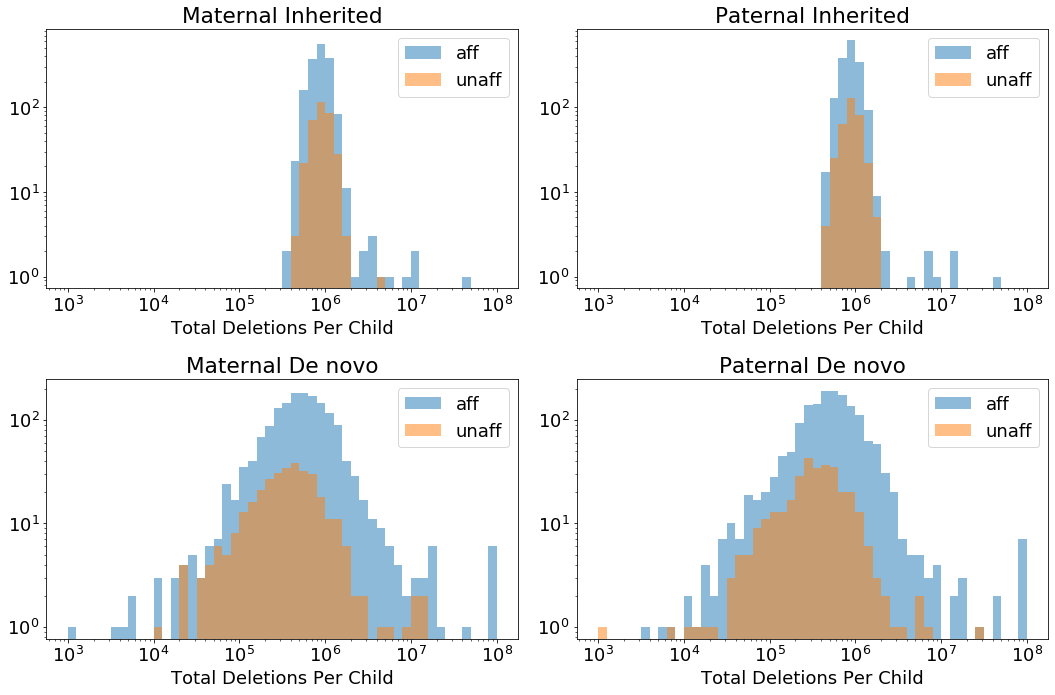

In [69]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

ax = plt.subplot(2, 2, 1)
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Maternal Inherited')
plt.legend()

plt.subplot(2, 2, 2, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_inh_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Paternal Inherited')
plt.legend()

ax = plt.subplot(2, 2, 3)
plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Maternal De novo')
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
plt.hist(np.clip([v for x, v in child_to_denovo_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
plt.hist(np.clip([v for x, v in child_to_denovo_pat_dels.items() if x in child_id_to_affected and child_id_to_affected[x] == '1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Paternal De novo')
plt.legend()


plt.tight_layout()
plt.show()

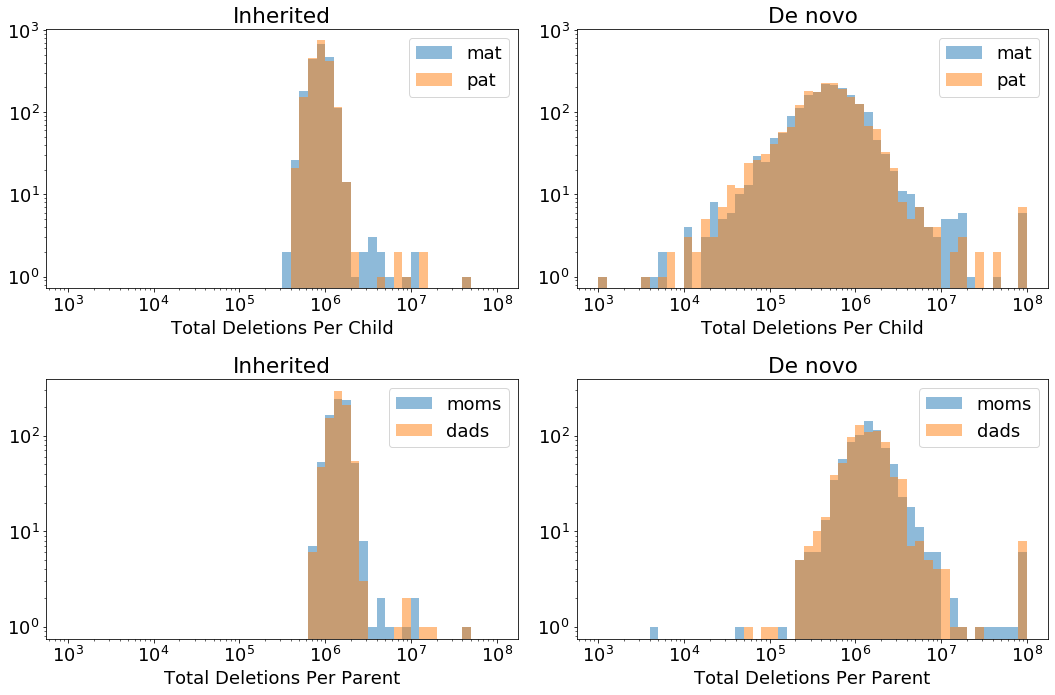

In [70]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

ax = plt.subplot(2, 2, 1)
plt.hist(np.clip(list(child_to_inh_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip(list(child_to_inh_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('Inherited')
plt.legend()

plt.subplot(2, 2, 2, sharey=ax)
plt.hist(np.clip(list(child_to_denovo_mat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='mat')
plt.hist(np.clip(list(child_to_denovo_pat_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='pat')
plt.xscale('log')
plt.xlabel('Total Deletions Per Child')
plt.title('De novo')
plt.legend()

ax = plt.subplot(2, 2, 3)
plt.hist(np.clip(list(mom_to_inh_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='moms')
plt.hist(np.clip(list(dad_to_inh_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dads')
plt.xscale('log')
plt.xlabel('Total Deletions Per Parent')
plt.title('Inherited')
plt.legend()

plt.subplot(2, 2, 4, sharey=ax)
plt.hist(np.clip(list(mom_to_denovo_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='moms')
plt.hist(np.clip(list(dad_to_denovo_dels.values()), bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='dads')
plt.xscale('log')
plt.xlabel('Total Deletions Per Parent')
plt.title('De novo')
plt.legend()

plt.tight_layout()
plt.show()

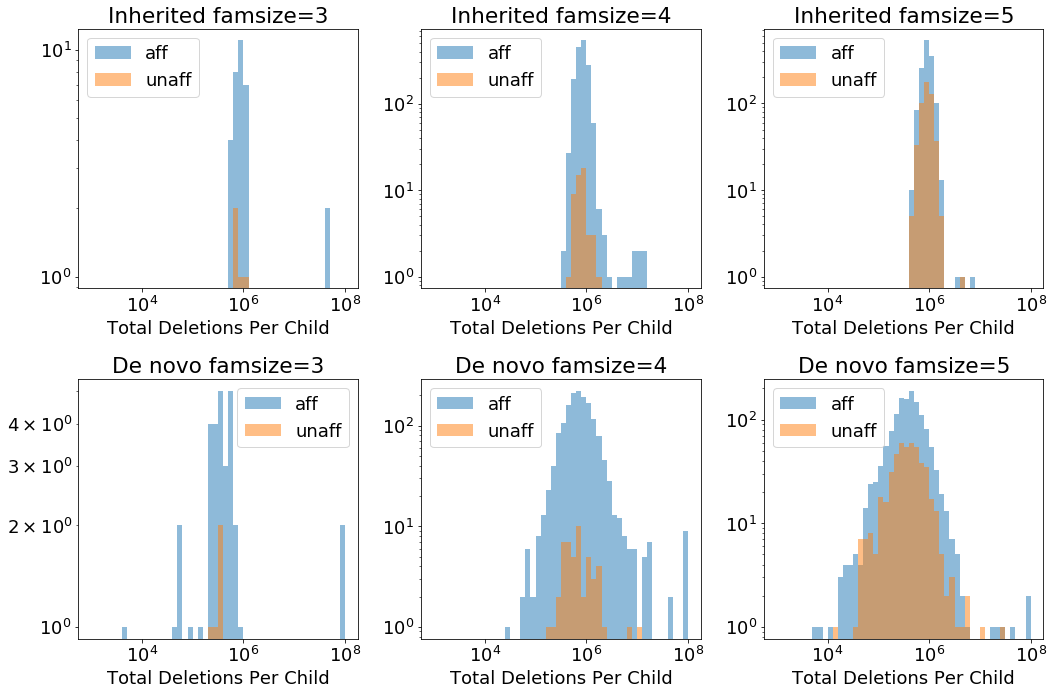

In [71]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 10))

bins = np.power(10.0, np.arange(3, 8.1, 0.1))

for famsize in [3, 4, 5]:
    plt.subplot(2, 3, famsize-2)
    plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'] + [v for x, v in child_to_inh_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
    plt.hist(np.clip([v for x, v in child_to_inh_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'] + [v for x, v in child_to_inh_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
    plt.xscale('log')
    plt.xlabel('Total Deletions Per Child')
    plt.title('Inherited famsize=%d' % famsize)
    plt.legend()

    plt.subplot(2, 3, famsize+1)
    plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'] + [v for x, v in child_to_denovo_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='2'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='aff')
    plt.hist(np.clip([v for x, v in child_to_denovo_mat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'] + [v for x, v in child_to_denovo_pat_dels.items() if ind_to_familysize[x] == famsize and x in child_id_to_affected and child_id_to_affected[x]=='1'], bins[0], bins[-2]), bins=bins, log=True, alpha=0.5, label='unaff')
    plt.xscale('log')
    plt.xlabel('Total Deletions Per Child')
    plt.title('De novo famsize=%d' % famsize)
    plt.legend()



plt.tight_layout()
plt.show()

In [72]:
deletions_of_interest = [d for d in all_deletions if d['length']>10**6 and not d['is_denovo']]

with open('../deletions_to_validate/%s_inherited.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

2:145735762-147489202
{'family': 'AU2125.AU2125202.AU2125201', 'chrom': '2', 'start_pos': 145735762, 'end_pos': 147489202, 'length': 1753441, 'phase_length': 3942, 'opt_start_pos': 145735762, 'opt_end_pos': 147489202, 'trans': ['AU2125303', 'AU2125302'], 'notrans': [], 'family_size': 4, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU2125202', 'father': 'AU2125201'}
4:115889766-118589497
{'family': 'AU2075.AU2075202.AU2075201', 'chrom': '4', 'start_pos': 115889766, 'end_pos': 118589497, 'length': 2699732, 'phase_length': 8726, 'opt_start_pos': 115889766, 'opt_end_pos': 118589497, 'trans': ['AU2075302', 'AU2075303'], 'notrans': ['AU2075301'], 'family_size': 5, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU2075202', 'father': 'AU2075201'}
9:28994599-30688235
{'family': 'AU1858.AU1858202.AU1858201', 'chrom': '9', 'start_pos': 28994599, 'end_pos': 30688235, 'length': 1693637, 'phase_length': 5315, 'opt_start_pos': 28994599, 'opt_end_pos': 30688235, 'tr

In [73]:
deletions_of_interest = [d for d in all_deletions if d['length']>10**7 and d['is_denovo']]

with open('../deletions_to_validate/%s_denovo.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

2:62321223-73877047
{'family': 'AU1388.AU1388202.AU1388201', 'chrom': '2', 'start_pos': 62321223, 'end_pos': 73877047, 'length': 11555825, 'phase_length': 28702, 'opt_start_pos': 62321223, 'opt_end_pos': 73877047, 'trans': ['AU1388301'], 'notrans': [], 'family_size': 4, 'is_mat': False, 'is_pat': True, 'is_denovo': True, 'mother': 'AU1388202', 'father': 'AU1388201'}
4:171276723-183256456
{'family': 'AU3199.AU3199202.AU3199201', 'chrom': '4', 'start_pos': 171276723, 'end_pos': 183256456, 'length': 11979734, 'phase_length': 44307, 'opt_start_pos': 171276723, 'opt_end_pos': 183256456, 'trans': ['AU3199303'], 'notrans': [], 'family_size': 5, 'is_mat': False, 'is_pat': True, 'is_denovo': True, 'mother': 'AU3199202', 'father': 'AU3199201'}
17:50522678-60684391
{'family': 'AU1388.AU1388202.AU1388201', 'chrom': '17', 'start_pos': 50522678, 'end_pos': 60684391, 'length': 10161714, 'phase_length': 23328, 'opt_start_pos': 50522678, 'opt_end_pos': 60684391, 'trans': ['AU1388302'], 'notrans': [], '

In [93]:
deletions_of_interest = [d for d in all_deletions if d['phase_length']>2*10**4 and d['is_denovo']]

with open('../deletions_to_validate/%s_denovo_confident.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

2:62321223-73877047
{'family': 'AU1388.AU1388202.AU1388201', 'chrom': '2', 'start_pos': 62321223, 'end_pos': 73877047, 'length': 11555825, 'phase_length': 28702, 'opt_start_pos': 62321223, 'opt_end_pos': 73877047, 'trans': ['AU1388301'], 'notrans': [], 'family_size': 4, 'is_mat': False, 'is_pat': True, 'is_denovo': True, 'mother': 'AU1388202', 'father': 'AU1388201'}
2:179525443-187918783
{'family': 'AU2998.AU2998202.AU2998201', 'chrom': '2', 'start_pos': 179525443, 'end_pos': 187918783, 'length': 8393341, 'phase_length': 25341, 'opt_start_pos': 179525443, 'opt_end_pos': 187918783, 'trans': ['AU2998302'], 'notrans': [], 'family_size': 4, 'is_mat': False, 'is_pat': True, 'is_denovo': True, 'mother': 'AU2998202', 'father': 'AU2998201'}
3:175385553-183953557
{'family': 'AU3199.AU3199202.AU3199201', 'chrom': '3', 'start_pos': 175385553, 'end_pos': 183953557, 'length': 8568005, 'phase_length': 21702, 'opt_start_pos': 175385553, 'opt_end_pos': 183953557, 'trans': ['AU3199301'], 'notrans': [],

In [90]:
deletions_of_interest = [d for d in all_deletions if d['phase_length']>2*10**3 and not d['is_denovo']]

with open('../deletions_to_validate/%s_inherited_confident.json' % dataset, 'w+') as f:
    json.dump(deletions_of_interest, f, indent=4)

for d in deletions_of_interest:
    print('%s:%d-%d' % (d['chrom'], d['start_pos'], d['end_pos']))
    print(d)

2:145735762-147489202
{'family': 'AU2125.AU2125202.AU2125201', 'chrom': '2', 'start_pos': 145735762, 'end_pos': 147489202, 'length': 1753441, 'phase_length': 3942, 'opt_start_pos': 145735762, 'opt_end_pos': 147489202, 'trans': ['AU2125303', 'AU2125302'], 'notrans': [], 'family_size': 4, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU2125202', 'father': 'AU2125201'}
3:2211941-2709401
{'family': 'AU0660.AU066001.AU066002', 'chrom': '3', 'start_pos': 2211941, 'end_pos': 2709401, 'length': 497461, 'phase_length': 2094, 'opt_start_pos': 2211941, 'opt_end_pos': 2709401, 'trans': ['AU066005', 'AU066004'], 'notrans': ['AU066003'], 'family_size': 5, 'is_mat': False, 'is_pat': True, 'is_denovo': False, 'mother': 'AU066001', 'father': 'AU066002'}
4:27991264-28437762
{'family': 'AU0951.AU0951202.AU0951201', 'chrom': '4', 'start_pos': 27991264, 'end_pos': 28437762, 'length': 446499, 'phase_length': 2170, 'opt_start_pos': 27991264, 'opt_end_pos': 28437762, 'trans': ['AU0951301'], 